In [1]:
import sys
from pathlib import Path

WORKSPACE_PATH = Path.cwd().parent.parent
SRC_PATH = str(WORKSPACE_PATH / "src")

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
    print(f"echo $PATH={sys.path}")

echo $PATH=['/Users/jeanmetz/workspace/playground-llm-pytorch/src', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python312.zip', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python3.12', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python3.12/lib-dynload', '', '/Users/jeanmetz/workspace/playground-llm-pytorch/.venv/lib/python3.12/site-packages']


In [2]:
from micrograd.engine import Operand
from micrograd.visualization import build_computation_graph

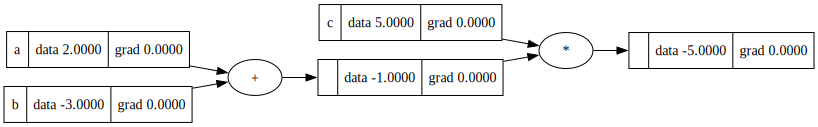

In [3]:
# A simple expression: y = (a * b) + c
a = Operand(2.0, label="a")
b = Operand(-3.0, label="b")
c = Operand(5, label="c")
y = (a + b) * c

build_computation_graph(y)

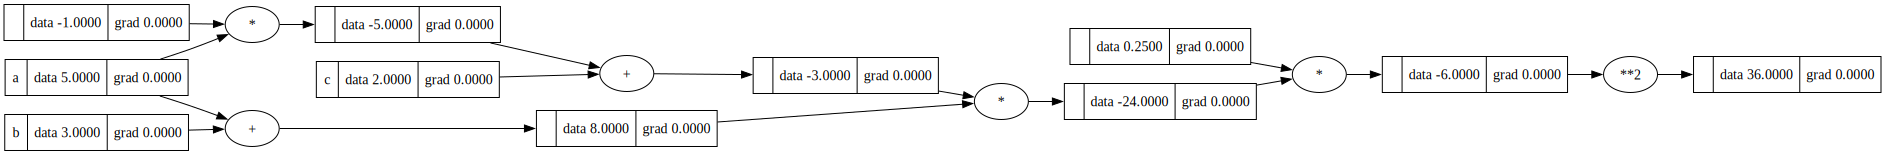

In [4]:
# using several operations:
a = Operand(5, label="a")
b = Operand(3, label="b")
c = Operand(2, label="c")
y = ((a + b) * (c - a) / 4) ** 2

build_computation_graph(y)

# The gradients calculation

Let's use a more complex expression to derive the gradients.
First, define a global expression to use as a reference in later steps.

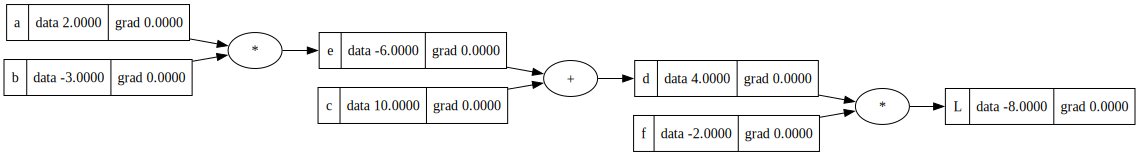

In [5]:
# The global expression: ((a * b) + c) * f
a = Operand(2.0, label="a")
b = Operand(-3.0, label="b")
c = Operand(10, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Operand(-2.0, label="f")
L = d * f
L.label = "L"
build_computation_graph(L)

define a function to simulate a small change to one variable and calculate the gradient of the output wrt to that variable, in the original expression (here we use a copy to not modify the reference graph).

In [6]:
# the test case in the video
def calc_local_grad_staging(target_label: str, h=0.001):
    # add h to the variable (in the second part) you want to check the gradient to

    # Here is a local copy of the global graph (expression) to avoid changing the original.
    a = Operand(2.0, label="a")
    b = Operand(-3.0, label="b")
    c = Operand(10, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Operand(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    a = Operand(2.0 + (h if target_label == "a" else 0), label="a")
    b = Operand(-3.0 + (h if target_label == "b" else 0), label="b")
    c = Operand(10 + (h if target_label == "c" else 0), label="c")

    e = a * b
    e.label = "e"
    if target_label == "e":
        e.data += h

    d = e + c
    d.label = "d"
    if target_label == "d":
        d.data += h

    f = Operand(-2.0 + (h if target_label == "f" else 0), label="f")

    L2 = d * f
    L.label = "L"

    grad = (L2 - L1) / h
    print(f"gradient: {grad.data}")

    return grad.data

# Finding the gradients

Let's call the `calc_local_grad_staging` function for each variable and set the respective gradient:

In [7]:
# manually setting all the gradients:
# starting from the output to the inputs (right to left) to simulate back propagation
L.grad = 1.0  # output's grad is always 1.0 (due to multiplicative nature of the chain rule)

f.grad = calc_local_grad_staging("f")
d.grad = calc_local_grad_staging("d")
e.grad = calc_local_grad_staging("e")
c.grad = calc_local_grad_staging("c")
b.grad = calc_local_grad_staging("b")
a.grad = calc_local_grad_staging("a")

gradient: 3.9999999999995595
gradient: -2.000000000000668
gradient: -2.000000000000668
gradient: -1.9999999999988916
gradient: -3.9999999999995595
gradient: 6.000000000000227


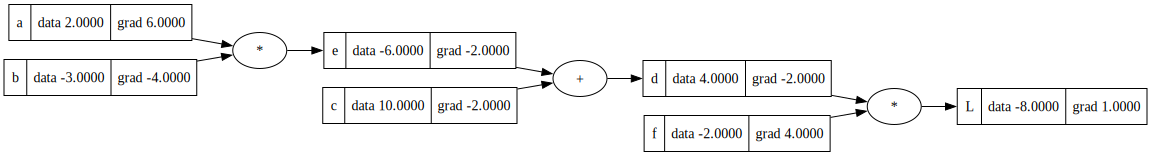

In [8]:
# visualize the grad changed.
build_computation_graph(L)

# Simulating 1-step of the optimization process

In [9]:
# nudge the inputs to try to make the output go up (simulate 1-step of the optmization)
nudge_size = 0.01

# only the leaf nodes of the expression
a.data += nudge_size * a.grad
b.data += nudge_size * b.grad
c.data += nudge_size * c.grad
f.data += nudge_size * f.grad

# the operations ...
e = a * b
d = e + c
L = d * f
print(L.data)  # expected a less negative L

-7.286496000000042


# A simple neuron

In [10]:
# simulate a neuron: x * w + b
# here we "define" a 2d x input (x1 and x2), with 2d weights (w1 and w2), and one bias.

# inputs
x1 = Operand(2.0, label="x1")
x2 = Operand(0.0, label="x2")

# weights
w1 = Operand(-3.0, label="w1")
w2 = Operand(1.0, label="w2")

# bias
b = Operand(6.881373587, label="b")

# the neuron expression: (x1 * w1) + (x2 * w2) + b
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1_x2w2 = x1w1 + x2w2
value = x1w1_x2w2 + b
# applying the activation function
output = value.tanh()

# give the labels to the intermediate nodes for better visualization
x1w1.label = "x1 * w1"
x2w2.label = "x2 * w2"
x1w1_x2w2.label = "(x1 * w1) + (x2 * w2)"
value.label = "(x1 * w1) + (x2 * w2) + b"
output.label = "output"

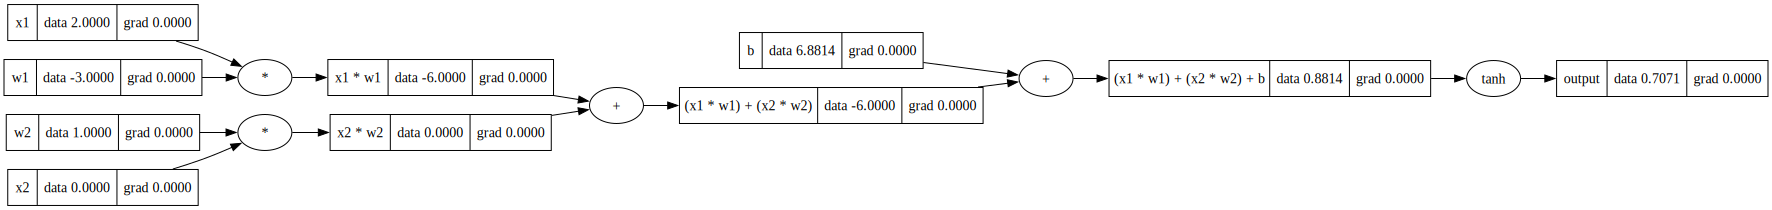

In [11]:
build_computation_graph(output)

In [12]:
# backprop 1 step ...

output.grad = 1.0

# since derivative of tanh is "1 - tanh^2 = 1 - 0.6044^2 = 0.5"
value.grad = 0.5

# since derivative for + operation is basically routing back ...
b.grad = 0.5
x1w1_x2w2.grad = 0.5

# another + operation ... flow back the gradient...
x1w1.grad = 0.5
x2w2.grad = 0.5

# derivative of the * operation
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

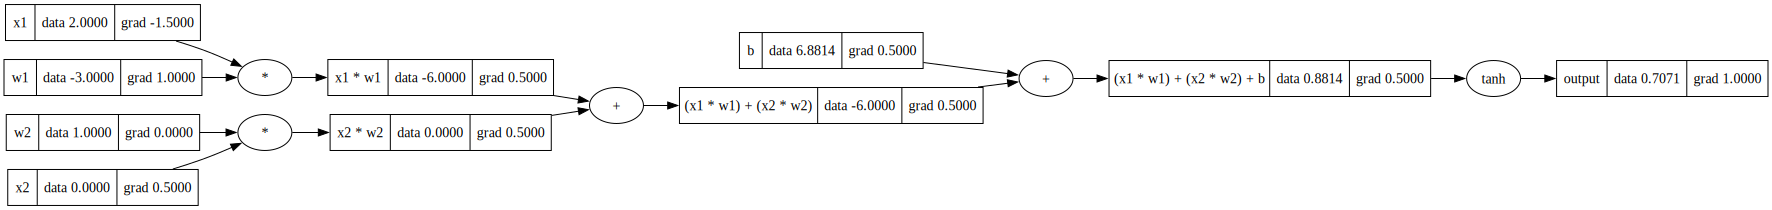

In [13]:
build_computation_graph(output)

In [14]:
# Rebuild the expression to use the backward() function on the output note

# inputs
x1 = Operand(2.0, label="x1")
x2 = Operand(0.0, label="x2")

# weights
w1 = Operand(-3.0, label="w1")
w2 = Operand(1.0, label="w2")

# bias
b = Operand(6.881373587, label="b")

# operations
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1_x2w2 = x1w1 + x2w2
value = x1w1_x2w2 + b
# applying the activation function
output = value.tanh()

# give the labels to the intermediate nodes for better visualization
x1w1.label = "x1 * w1"
x2w2.label = "x2 * w2"
x1w1_x2w2.label = "(x1 * w1) + (x2 * w2)"
value.label = "(x1 * w1) + (x2 * w2) + b"
output.label = "output"

In [15]:
output.grad = 1.0
output._chain_backward_step()
value._chain_backward_step()
x1w1_x2w2._chain_backward_step()
x2w2._chain_backward_step()
x1w1._chain_backward_step()

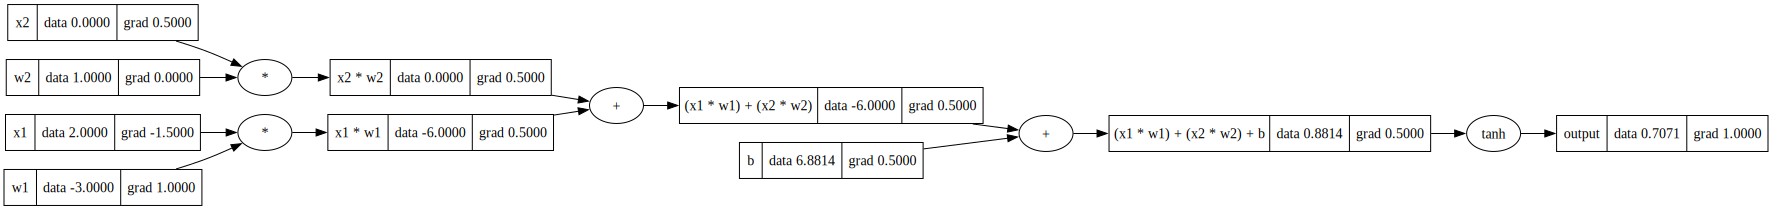

In [16]:
# should draw the same graph as before
build_computation_graph(output)

# The backward() function

Encapsulating the computation into a function

In [17]:
def backward(out_operand, v: bool = False, vv: bool = False):
    topological_order = []
    visited = set()

    def _dfs_build_topological_order(node):
        if node not in visited:
            visited.add(node)
            for ancestor in node._src_operands:
                _dfs_build_topological_order(ancestor)
            topological_order.append(node)

    _dfs_build_topological_order(out_operand)
    out_operand.grad = 1.0
    for operand in reversed(topological_order):
        if v or vv:
            if not vv and len(operand._src_operands) == 0:
                continue
            print(f"Operand: {operand.label}")
        operand._chain_backward_step()

Operand: o
Operand: (x1 * w1) + (x2 * w2) + b
Operand: (x1 * w1) + (x2 * w2)
Operand: x2 * w2
Operand: x1 * w1


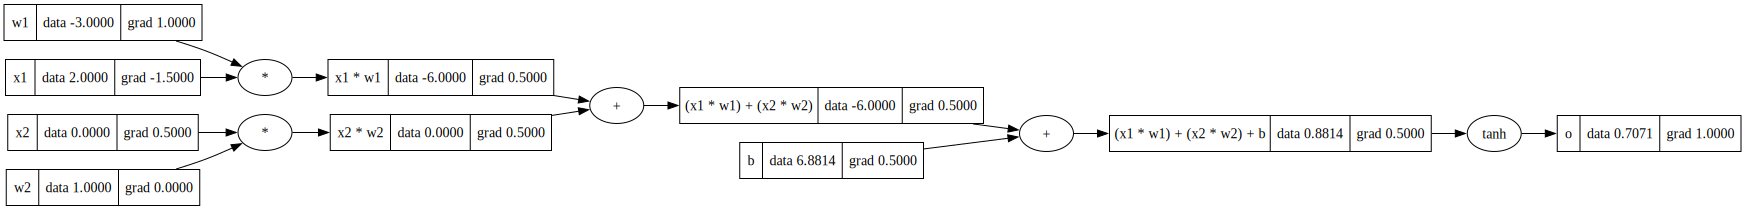

In [18]:
# Reset expression:
x1 = Operand(2.0, label="x1")
x2 = Operand(0.0, label="x2")

# weights
w1 = Operand(-3.0, label="w1")
w2 = Operand(1.0, label="w2")

# bias
b = Operand(6.881373587, label="b")

# operations
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1_x2w2 = x1w1 + x2w2
value = x1w1_x2w2 + b
# applying the activation function
output = value.tanh()

x1w1.label = "x1 * w1"
x2w2.label = "x2 * w2"
x1w1_x2w2.label = "(x1 * w1) + (x2 * w2)"
value.label = "(x1 * w1) + (x2 * w2) + b"
output.label = "o"

backward(output, v=True)
build_computation_graph(output)

# Sanity check: the case of node reuse in the expression

In [19]:
a = Operand(3.0, label="a")
b = a + a
b.label = "b"
b.backward()

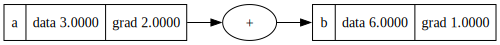

In [20]:
build_computation_graph(b)

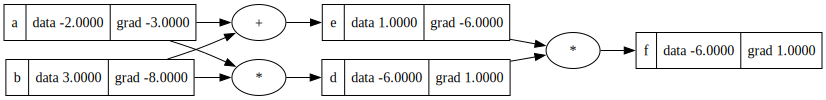

In [21]:
a = Operand(-2.0, label="a")
b = Operand(3.0, label="b")

d = a * b
e = a + b
f = d * e

d.label = "d"
e.label = "e"
f.label = "f"

f.backward()
build_computation_graph(f)

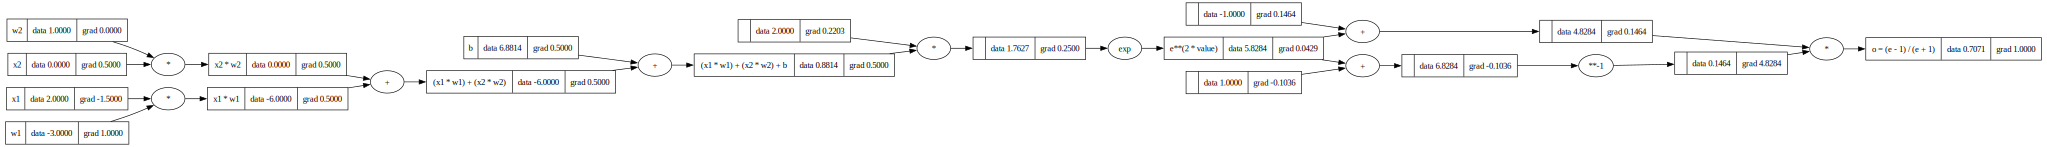

In [22]:
# break down the tanh into smaller components

x1 = Operand(2.0, label="x1")
x2 = Operand(0.0, label="x2")

# weights
w1 = Operand(-3.0, label="w1")
w2 = Operand(1.0, label="w2")

# bias
b = Operand(6.881373587, label="b")

# operations
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1_x2w2 = x1w1 + x2w2
value = x1w1_x2w2 + b

# ----------------------------------------
# decomposing tanh
# applying the activation function
e = (2 * value).exp()
output = (e - 1) / (e + 1)
# ----------------------------------------

x1w1.label = "x1 * w1"
x2w2.label = "x2 * w2"
x1w1_x2w2.label = "(x1 * w1) + (x2 * w2)"
value.label = "(x1 * w1) + (x2 * w2) + b"
e.label = "e**(2 * value)"
output.label = "o = (e - 1) / (e + 1)"


output.backward()
build_computation_graph(output)